# Chapter 7

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from sklearn import datasets
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import _name_estimators, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

plt.style.use({'figure.facecolor': 'white'})

## 7.2

In [2]:
print(np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])))

ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
print(np.argmax(p))

1
[0.58 0.42]
0


In [28]:
class MajorityVoteClassfier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote="classlabel", weights=None):
        self.classifiers = classifiers
        self.named_classfiers = {key: value for key, value in _name_estimators((classifiers))}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in {"probability", "classlabel"}:
            raise ValueError("vote must bi 'probability' or 'classlabel': got (vote=%r)" % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("Number of classifiers and weights must bi equal; got %d weights, %d classifiers" % (len(self.weights), len(self.classifiers)))

        self.labelnc_ = LabelEncoder()
        self.labelnc_.fit(y)
        self.classes_ = self.labelnc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelnc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == "probability":
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)

        maj_vote = self.labelnc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassfier, self).get_params(deep=False)
        else:
            out = self.named_classfiers.copy()
            for name, step in self.named_classfiers.items():
                for key, value in step.get_params(deep=True).items():
                    out["%s__%s" % (name, key)] = value
            return out

In [29]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

clf1 = LogisticRegression(penalty="l2", C=0.001, solver="lbfgs")
clf2 = DecisionTreeClassifier(max_depth=1, criterion="entropy", random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")
pipe1 = Pipeline([["sc", StandardScaler()], ["clf", clf1]])
pipe3 = Pipeline([["sc", StandardScaler()], ["clf", clf3]])
clf_labels = ["Logistic regression", "Decision tree", "KNN"]
print("10-fold cross validation\n")
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring="roc_auc")
    print(f"ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

print("="*10, "MajorityVoteClassfier", "="*10)

mv_clf = MajorityVoteClassfier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ["Majority voting"]
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring="roc_auc")
    print(f"ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

10-fold cross validation

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
========== MajorityVoteClassfier ==========
ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


## 7.3

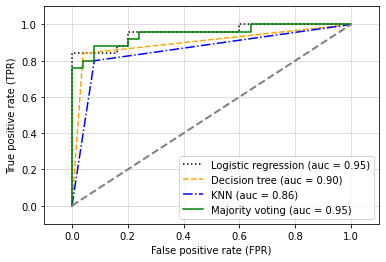

In [30]:
colors = ["black", "orange", "blue", "green"]
linestyles = [":", "--", "-.", "-"]
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]  # 各データのクラスラベル1である確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label="%s (auc = %0.2f)" % (label, roc_auc))
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False positive rate (FPR)")
plt.ylabel("True positive rate (TPR)")
plt.show()

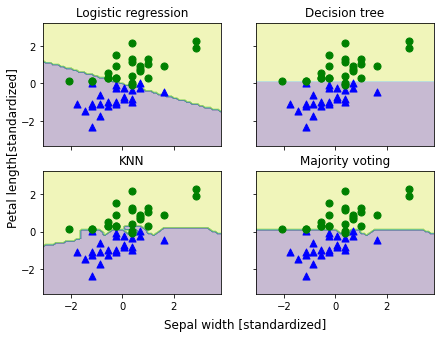

 0.983 +/-  0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
 0.983 +/-  0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
 0.967 +/-  0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
 0.983 +/-  0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
 0.983 +/-  0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
 0.967 +/-  0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Accuracy:  0.98


In [34]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c="blue", marker="^", s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c="green", marker="o", s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5., s="Sepal width [standardized]", ha="center", va="center", fontsize=12)
plt.text(-12.5, 4.5, s="Petal length[standardized]", ha="center", va="center", fontsize=12, rotation=90)
plt.show()

mv_clf.get_params()

params = {"decisiontreeclassifier__max_depth": [1, 2],
          "pipeline-1__clf__C": [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring="roc_auc")
grid.fit(X_train, y_train)
for r, _ in enumerate(grid.cv_results_["mean_test_score"]):
    print(f"{grid.cv_results_['mean_test_score'][r]: 0.3f} +/- {grid.cv_results_['std_test_score'][r] / 2.0: 0.2f} {grid.cv_results_['params'][r]}")
print(f"Best parameters: {grid.best_params_}")
print(f"Accuracy: {grid.best_score_: 0.2f}")

## 7.4

Decision tree train/test accuracies  1.000/ 0.833
Decision tree train/test accuracies  1.000/ 0.917


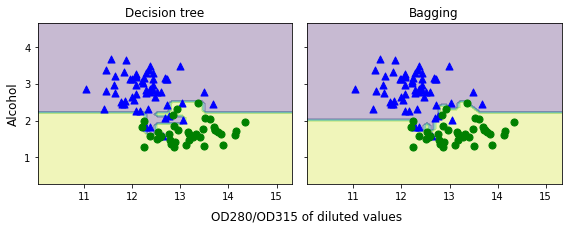

In [45]:
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)
df_wine.columns = ["Class label", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phnols", "Flavanoids", "Nonflavanoid phnols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
df_wine = df_wine[df_wine["Class label"] != 1]
y = df_wine["Class label"].values
X = df_wine[["Alcohol", "OD280/OD315 of diluted wines"]].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

tree = DecisionTreeClassifier(criterion="entropy", max_depth=None, random_state=1)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f"Decision tree train/test accuracies {tree_train: .3f}/{tree_test: .3f}")

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f"Decision tree train/test accuracies {bag_train: .3f}/{bag_test: .3f}")

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex="col", sharey="row", figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, bag], ["Decision tree", "Bagging"]):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c="blue", marker="^", s=50)
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c="green", marker="o", s=50)
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("Alcohol", fontsize=12)
plt.tight_layout()
plt.text(0, -0.2, s="OD280/OD315 of diluted values", ha="center", va="center", fontsize=12, transform=axarr[1].transAxes)
plt.show()

## 7.5

Decision tree train/test accuracies  0.916/ 0.875
Decision tree train/test accuracies  1.000/ 0.917


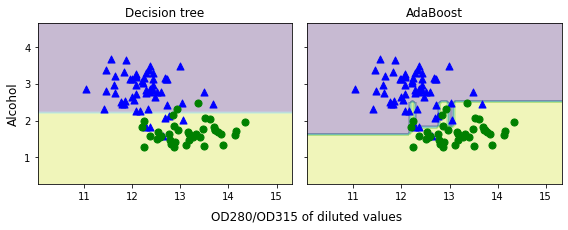

In [48]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=1, random_state=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f"Decision tree train/test accuracies {tree_train: .3f}/{tree_test: .3f}")

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f"Decision tree train/test accuracies {ada_train: .3f}/{ada_test: .3f}")

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex="col", sharey="row", figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, ada], ["Decision tree", "AdaBoost"]):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c="blue", marker="^", s=50)
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c="green", marker="o", s=50)
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("Alcohol", fontsize=12)
plt.tight_layout()
plt.text(0, -0.2, s="OD280/OD315 of diluted values", ha="center", va="center", fontsize=12, transform=axarr[1].transAxes)
plt.show()
